## Face Croper

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import tqdm
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
# Path to Directories
with_mask = "./dataset/with_mask/"
without_mask = "./dataset/without_mask/"

In [ ]:
# Create MTCNN Object
detector = MTCNN()

In [ ]:
# Without Mask

# Counter to name images
counter = 0

for imageName in tqdm.tqdm(os.listdir(without_mask)):
    
    # Path to the Image
    pathToImage = f"./dataset/without_mask/{imageName}"
    
    # Load the Image
    image = cv2.imread(pathToImage)
    
    # Detect Faces
    detectedFaces = detector.detect_faces(image)
    
    if len(detectedFaces) != 0:
        
        # For Every detected face
        for face in detectedFaces:

            # Get the face coordinates
            x, y, width, height = face['box']
            
            # Crop the face from orignal image
            faceCrop = image[y: y+height, x: x+width]
            
            try: 
                # Save the image
                cv2.imwrite(f"./dataset/onlyFaces/withoutMask/noMask_{counter}.jpg", faceCrop)
            except:
                continue
            
            # Increase the counter
            counter += 1
    else:
        continue

In [ ]:
face_cascade = cv2.CascadeClassifier("./haarcascade_frontalface_default.xml")

In [ ]:
# With Mask

# Counter to name images
counter = 0

for imageName in tqdm.tqdm(os.listdir(with_mask)):
# for imageName in os.listdir(with_mask):
    # Path to image
    pathToImage = f"./dataset/with_mask/{imageName}"
    
    # Load image
    image = cv2.imread(pathToImage)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect Faces
    detectedFaces = face_cascade.detectMultiScale(gray, 1.1, 5, flags=cv2.CASCADE_SCALE_IMAGE)
    
    # For every detected face
    for face in detectedFaces:
        
        # Get the face coordinates
        x, y, width, height = face
        
        # Crop the face from orignal image
        faceCrop = image[y: y+height, x: x+width]
        
        try: 
            # Save the image
            cv2.imwrite(f"./dataset/onlyFaces/withMask/withMask_{counter}.jpg", faceCrop)
        except:
            continue
            
        # Increase the counter
        counter += 1
    else:
        continue
    

## Data Processing

In [42]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [32]:
# Load data and generate labels
images = []
labels = []

for path in list(paths.list_images("./dataset/onlyFaces/")):
    
    # load the input image (224x224) and preprocess it
    image = load_img(path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    # Append The data
    images.append(image)
    
    if "noMask" in path:
        label = 0
    else:
        label = 1
    labels.append(label)

# convert the data and labels to NumPy arrays
images = np.array(images, dtype="float32")
labels = np.array(labels)

In [33]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [34]:
# Train Test Split
(trainX, testX, trainY, testY) = train_test_split(images, labels,
test_size=0.20, stratify=labels, random_state=42)

In [35]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [36]:
# Model

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

/Users/ibtihajtahir/anaconda3/envs/tf/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 3s 0us/step


In [38]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [39]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Train for 24 steps, validate on 194 samples
Epoch 1/20
24/24 [==============================] - 39s 2s/step - loss: 0.6626 - accuracy: 0.6784 - val_loss: 0.6794 - val_accuracy: 0.5417
Epoch 2/20
24/24 [==============================] - 34s 1s/step - loss: 0.4015 - accuracy: 0.8229 - val_loss: 0.5043 - val_accuracy: 0.7396
Epoch 3/20
24/24 [==============================] - 33s 1s/step - loss: 0.3019 - accuracy: 0.8851 - val_loss: 0.4465 - val_accuracy: 0.7812
Epoch 4/20
24/24 [==============================] - 33s 1s/step - loss: 0.2385 - accuracy: 0.9149 - val_loss: 0.3064 - val_accuracy: 0.9115
Epoch 5/20
24/24 [==============================] - 33s 1s/step - loss: 0.1947 - accuracy: 0.9419 - val_loss: 0.2999 - val_accuracy: 0.9062
Epoch 6/20
24/24 [==============================] - 33s 1s/step - loss: 0.1443 - accuracy: 0.9500 - val_loss: 0.2307 - val_accuracy: 0.9531
Epoch 7/20
24/24 [==============================] - 33s 1s/step - loss: 0.1514 - accuracy: 0

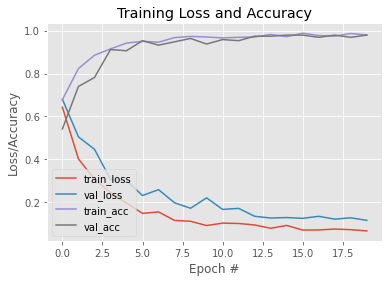

In [49]:
N = EPOCHS
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()